In [1]:
import torch
from torchvision import datasets, transforms
from PIL import Image

In [2]:
trainset = datasets.Flowers102(root='./data', split='train',download=False) #use download True if you don't have the dataset

In [3]:
im = trainset[0][0]

In [4]:
tensor = transforms.ToTensor()(im)

In [5]:
tensor

tensor([[[0.0353, 0.0353, 0.0353,  ..., 0.5608, 0.5569, 0.5608],
         [0.0392, 0.0392, 0.0392,  ..., 0.5608, 0.5569, 0.5608],
         [0.0510, 0.0510, 0.0392,  ..., 0.5569, 0.5608, 0.5647],
         ...,
         [0.0824, 0.0902, 0.0980,  ..., 0.4745, 0.4627, 0.4627],
         [0.0863, 0.0902, 0.0980,  ..., 0.4667, 0.4627, 0.4627],
         [0.0863, 0.0941, 0.0980,  ..., 0.4588, 0.4627, 0.4627]],

        [[0.0745, 0.0745, 0.0784,  ..., 0.3961, 0.3725, 0.3725],
         [0.0784, 0.0784, 0.0824,  ..., 0.3961, 0.3725, 0.3725],
         [0.0824, 0.0824, 0.0824,  ..., 0.3922, 0.3765, 0.3765],
         ...,
         [0.1882, 0.1961, 0.2039,  ..., 0.3765, 0.3569, 0.3569],
         [0.1922, 0.1961, 0.2039,  ..., 0.3686, 0.3569, 0.3569],
         [0.1922, 0.2000, 0.2039,  ..., 0.3608, 0.3569, 0.3569]],

        [[0.0314, 0.0314, 0.0235,  ..., 0.5922, 0.5765, 0.5765],
         [0.0353, 0.0353, 0.0275,  ..., 0.5922, 0.5765, 0.5765],
         [0.0392, 0.0392, 0.0275,  ..., 0.5804, 0.5804, 0.

In [6]:
def display(tensor):
    return transforms.functional.to_pil_image(tensor)

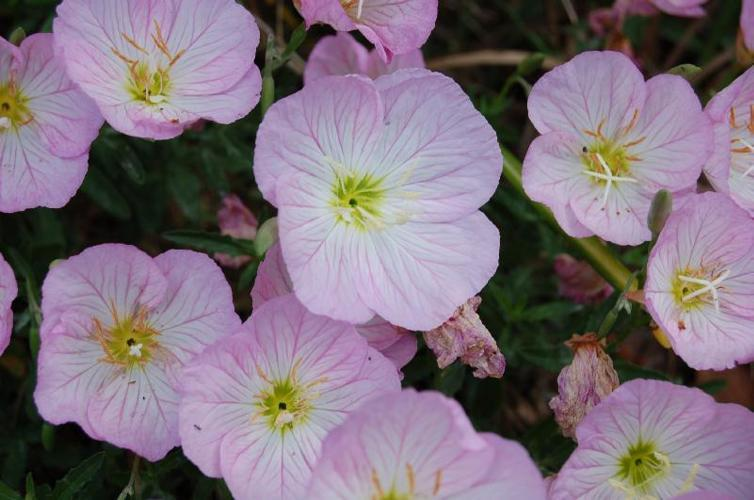

In [7]:
display(tensor)

We assume sRGB. We can convert to CIEXYZ with the formula given here https://en.wikipedia.org/wiki/SRGB#From_sRGB_to_CIE_XYZ 

We can then transform CIEXYZ to CIELAB https://en.wikipedia.org/wiki/CIELAB_color_space#From_CIEXYZ_to_CIELAB where we assume Standard Illuminant D65


## Converting RGB to LAB and vice versa

We assume that the tensor input has shape 3 x width x height where the first axis is made for the RGB channel.

In [8]:
def rgbtoxyz(tensor):
    c = 0.04045
    rgblinear = tensor*(tensor<=c)/12.92 + ((tensor+0.055)/1.055)**2.4*(tensor>c)
    matrix = torch.tensor([[0.4124564, 0.3575761, 0.1804375], [0.2126729, 0.7151522, 0.0721750], [0.0193339, 0.119192, 0.9503041]])
    return torch.einsum('ij,jkl->ikl', matrix, rgblinear)

def xyztolab(tensor):
    xn = 95.0489
    yn = 100 
    zn = 108.8840 
    xxn, yyn, zzn = tensor[0]/xn, tensor[1]/yn, tensor[2]/zn
    def f(t):
        delta = 6/29
        return t**(1/3)*(t>delta**3) + (t/3 * delta**(-2) +4/29)*(t<=delta**3)
    fx, fy, fz = f(xxn), f(yyn), f(zzn)
    L = 116*fy-16
    a = 500*(fx-fy)
    b = 200*(fy-fz)
    return torch.stack((L,a,b))



def rgbtolab(tensor):
    return xyztolab(rgbtoxyz(tensor))
    

In [9]:
def labtoxyz(tensor):
    xn = 95.0489
    yn = 100 
    zn = 108.8840 
    def finv(t):
        delta = 6/29
        return t**3 * (t>delta) + 3*delta**2*(t-4/29) * (t<=delta)
    temp = (tensor[0]+16)/116
    x = xn * finv(temp+tensor[1]/500)
    y = yn*finv(temp)
    z = zn*finv(temp-tensor[2]/200)
    return torch.stack((x,y,z))

def xyztorgb(tensor):
    matrix = torch.tensor([[3.2404542,-1.5371385, -0.4985314], [-0.969266, 1.8760108, 0.0415560], [0.0556434, -0.2040259, 1.0572252]])
    rgblinear = torch.einsum('ij,jkl->ikl', matrix, tensor)
    c = 0.0031308
    return 12.92*rgblinear*(rgblinear<=0.0031308) + 1.055*(rgblinear*(rgblinear>0.0031308))**(1/2.4) - 0.055*(rgblinear>0.0031308)

def labtorgb(tensor):
    return xyztorgb(labtoxyz(tensor))

In [10]:
# Check if converting format back and forth is ok
print(torch.all(torch.isclose(tensor,xyztorgb(rgbtoxyz(tensor)), atol = 1e-05)))
print(torch.all(torch.isclose(tensor,labtorgb(rgbtolab(tensor)), atol = 1e-05)))

tensor(True)
tensor(True)


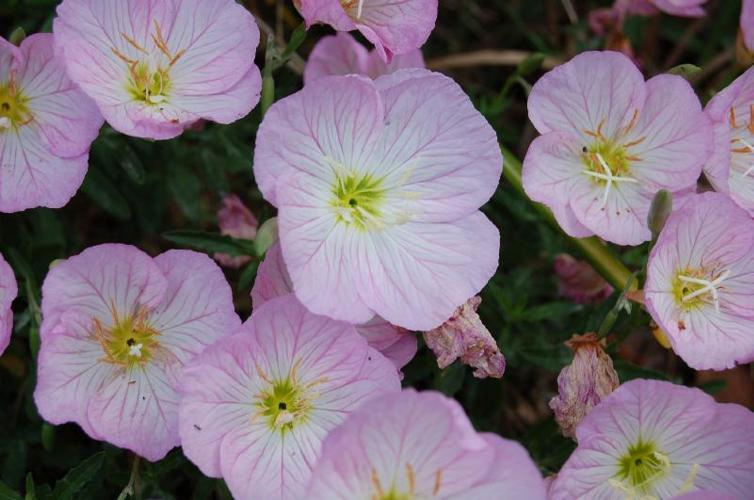

In [11]:
# converted image
converted = labtorgb(rgbtolab(tensor))
display(converted)

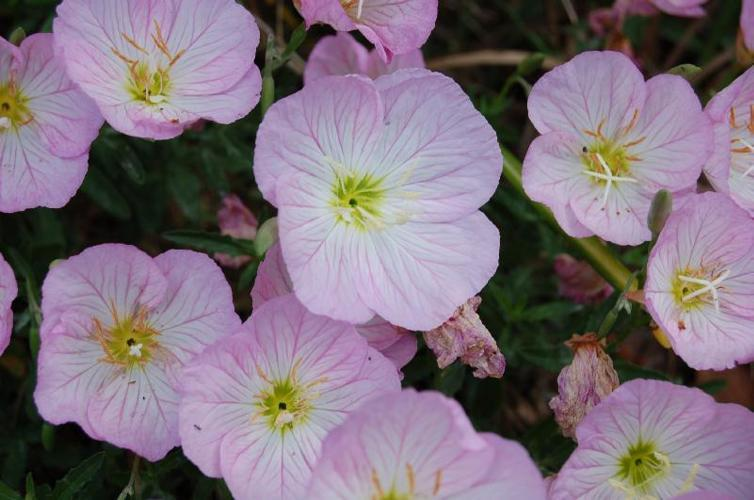

In [12]:
# original image
im.convert("RGB")


### Visualization of RGB to LAB

We convert an image to it's LAB format (L, a, b), then visualize the RGB version of (L,0,0), (0,a,0), (0,0,b).

In [13]:
lab = rgbtolab(tensor)
l,a,b = lab[0], lab[1], lab[2]
zeros = torch.zeros_like(l)
l = torch.stack((l,zeros,zeros))
a = torch.stack((zeros,a,zeros))
b = torch.stack((zeros,zeros,b))

In [14]:
lrgb, argb, brgb = labtorgb(l), labtorgb(a), labtorgb(b)


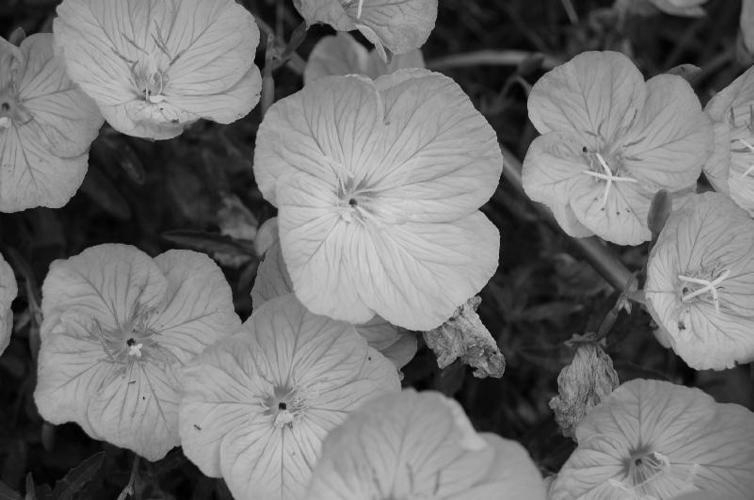

In [15]:
display(lrgb)


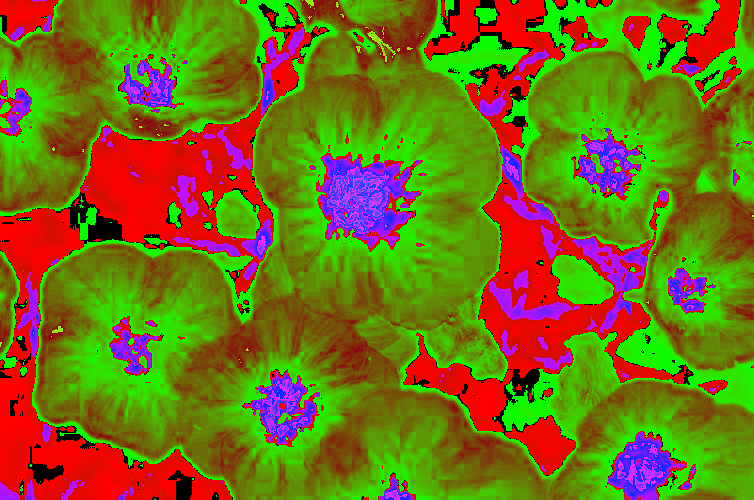

In [16]:
display(argb)


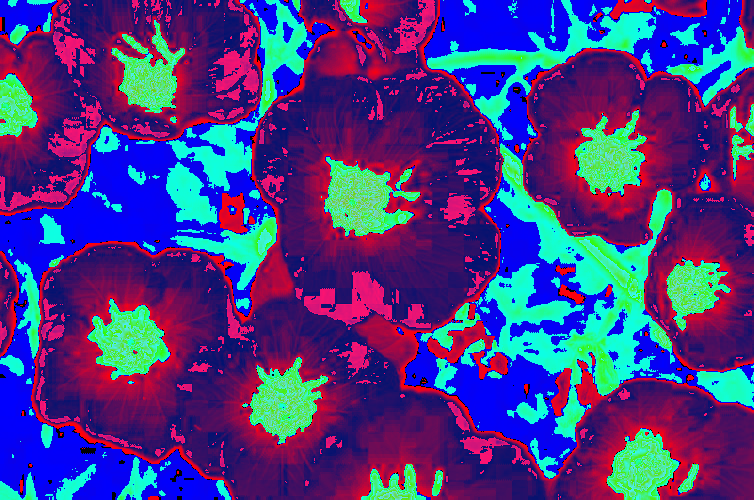

In [17]:
display(brgb)


### Grayscale to LAB

Trying to understand how L (perceptual lightness) compare to "grayscale". We do this by extracting the L part of a grayscale image.

In [18]:
tensor_gs = transforms.Grayscale(num_output_channels=3)(tensor)

lab = rgbtolab(tensor_gs)
l,a,b = lab[0], lab[1], lab[2]
zeros = torch.zeros_like(l)
l = torch.stack((l,zeros,zeros))
a = torch.stack((zeros,a,zeros))
b = torch.stack((zeros,zeros,b))
lrgb, argb, brgb = labtorgb(l), labtorgb(a), labtorgb(b)

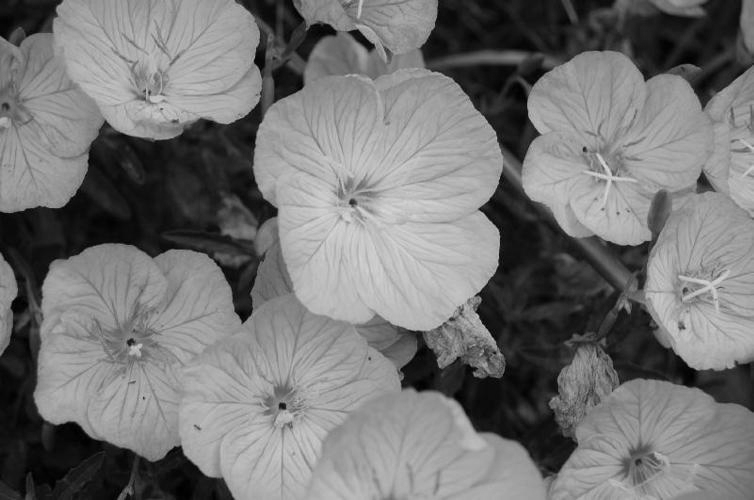

In [19]:
# original -> grayscale
display(tensor_gs)

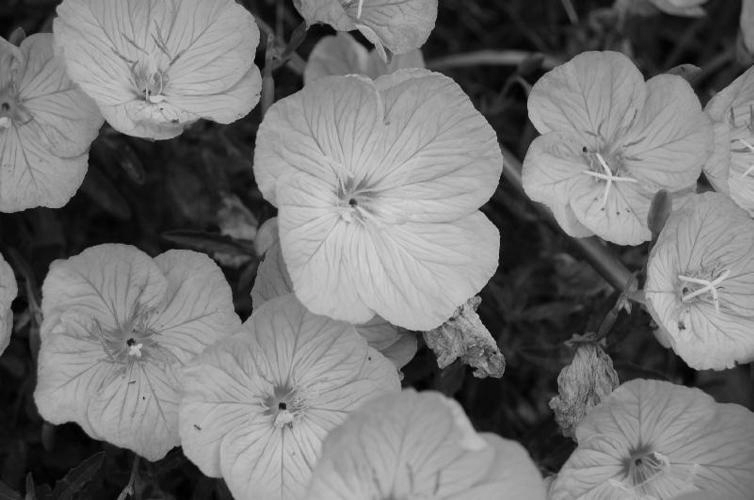

In [20]:
# original -> grayscale -> (L,0,0) [throwing away a,b] -> rgb
display(lrgb)

In [21]:
# this shows that a and b are essentially zero. Therefore transforming a grayscale image to its LAB format approximately results in (L,0,0)
torch.max(a),torch.min(a), torch.max(b), torch.min(b)

(tensor(0.), tensor(-0.0005), tensor(0.0001), tensor(0.))

### ISSUE: L of a colored image and the L of its greyscale version are not identical.

In [22]:
lab = rgbtolab(tensor_gs)
l_gs= lab[0]
zeros = torch.zeros_like(l_gs)
l_gs = torch.stack((l_gs,zeros,zeros))

lab = rgbtolab(tensor)
l = lab[0]
zeros = torch.zeros_like(l)
l = torch.stack((l,zeros,zeros))

diff = l-l_gs 
torch.max(diff), torch.min(diff), torch.mean(torch.abs(diff))

(tensor(0.6131), tensor(-0.2271), tensor(0.0239))

# Using LAB for coloring

In training we have pair of images (grayscale, colored). In test we only have grayscale. 

Of course we should transform the colored image to (L,a,b). Then we have two different possibilities (this is distinct because of the issue raised in the cell above):
1. Use the grayscale format and directly try to learn a,b
2. Transform the grayscale format to (L_gs, a_gs, b_gs) (knowing that a_gs, b_gs are approximately 0), then try to learn a,b from L_gs. 

Once a,b are learned and we get the prediction a',b', we can transform (L_gs, a', b') to rgb to get the desired rgb answer.